In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import math
from operator import itemgetter
from scipy import interpolate
from ctypes import *
from scipy import ndimage
from PIL import Image, ImageDraw 

In [2]:
image = Image.open('images/image.jpg') #Открываем изображение. 

In [3]:
copy_image = image.copy() #создаём копию
draw = ImageDraw.Draw(copy_image) #Создаем инструмент для рисования. 
img = np.array(copy_image)
arr = np.copy(copy_image)
h = len(arr) #высота
w = len(arr[0]) #длина

# Преобразование цветного изображения в полутоновое

In [4]:
for i in range(w):
    for j in range(h):
        r = arr[j][i][0]*0.2126
        g = arr[j][i][1]*0.7152
        b = arr[j][i][2]*0.0722
        S = r + g + b
        draw.point((i, j), (int(S), int(S), int(S)))
copy_image.save("images/Преобразование в полутоновое.jpg", "JPEG") #сохраняем готовое изображение

# Построение гистограмм изображения 

In [5]:
ColorChannel = ['ALL','RED','GREEN','BLUE']
R_color, G_color, B_color, All_color = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)

#наполняем массивы, подсчитывая сркость каждого пикселя
for i in range(w):
    for j in range(h):
        r = arr[j][i][0]
        g = arr[j][i][1]
        b = arr[j][i][2]
        R_color[r] += 1
        G_color[g] += 1
        B_color[b] += 1
        All_color[r] += 1
        All_color[g] += 1
        All_color[b] += 1

In [6]:
#для удобства отображения цвета зададим функции
def RED(red):
    return '#%02x%02x%02x' % (red, 0, 0)
def GREEN(green):
    return '#%02x%02x%02x' % (0, green, 0)
def BLUE(blue):
    return '#%02x%02x%02x' % (0, 0, blue)
def ALL(All):
    return '#%02x%02x%02x' % (All, All, All)

In [7]:
def draw_histogram(color):
    fig, ax = plt.subplots()

    if (color == 'RED'):
        for i in range(0, 256):
            plt.bar(i, R_color[i], color = RED(i), alpha=0.8)
        plt.title('Гистограмма красного канала', fontdict={'size':20})
    elif (color == 'GREEN'):
        for i in range(0, 256):
            plt.bar(i, G_color[i], color = GREEN(i), alpha=0.8)
        plt.title('Гистограмма зелёного канала', fontdict={'size':20})
    elif (color == 'BLUE'):
        for i in range(0, 256):
            plt.bar(i, B_color[i], color = BLUE(i), alpha=0.8)
        plt.title('Гистограмма синего канала', fontdict={'size':20})
    elif (color == 'ALL'):
        for i in range(0, 256):
            plt.bar(i, All_color[i], color = ALL(i), edgecolor='black', width = 2, linewidth = 0.5, alpha=0.8)
        plt.title('Гистограмма суммарной яркости', fontdict={'size':20})

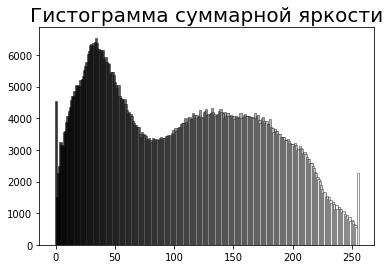

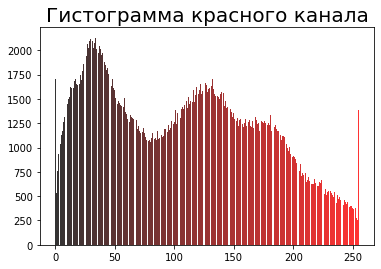

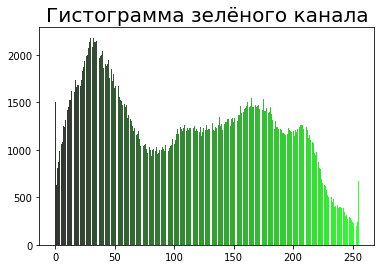

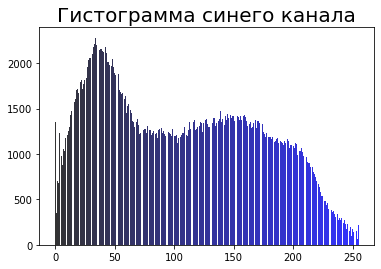

In [8]:
for color in ColorChannel:
    draw_histogram(color)

# Бинаризация полутонового изображения

In [9]:
def Bradley_threshold(_image):

    w, h = _image.width, _image.height
    s, t = w//8, 0.15
    summ = c_uint32(0)
    count = c_uint32(0)
    pixels=[]
    int_img = np.ndarray(shape=(w, h), dtype=c_int64)
    
    #рассчитываем интегральное изображение
    for i in range(w):
        summ.value = 0
        for j in range(h):
            summ.value += sum(_image.getpixel((i, j)))
            if i != 0:
                int_img[i, j] = int_img[i - 1, j] + summ.value
            else:
                int_img[i, j] = summ.value

    #находим границы для локальных областей
    x1, x2, y1, y2 = c_uint16(0), c_uint16(0), c_uint16(0), c_uint16(0)
    for i in range(w):
        pixels.append([])
        for j in range(h):
            x1.value = max(i - s // 2, 0)
            x2.value = min(i + s // 2, w - 1)
            y1.value = max(j - s // 2, 0)
            y2.value = min(j + s // 2, h - 1)

            count.value = (x2.value - x1.value) * (y2.value - y1.value)

            summ.value = int_img[x2.value][y2.value] - int_img[x1.value][y2.value] - \
                int_img[x2.value][y1.value] + int_img[x1.value][y1.value]

            if sum(_image.getpixel((i, j))) * count.value < summ.value * (1.0 - t):
                pixels[i].append([0, 0, 0])
            else:
                pixels[i].append([255, 255, 255])
    return pixels

In [10]:
binary = ndimage.rotate(Bradley_threshold(copy_image),90)

norm = plt.Normalize(vmin=binary.min(), vmax=binary.max())
im = norm(binary)
plt.imsave('test.jpg', im)

temp = Image.open('test.jpg')
rotated_image = temp.transpose(Image.FLIP_LEFT_RIGHT).rotate(180) #поворачиваем изображение
rotated_image.save('images/Бинаризация полутонового изображения.jpg') #сохраняем его
